In [1]:
# Import common modules and set global configs
from project_utils.common_imports import *

# Specific imports for data, augmentation, model, and evaluation
from project_utils.loading_utils import main_data_processing_pipeline
from project_utils.data_augmentor_and_generator import data_generator
from project_utils.model_architect import get_vit_model, macro_f1_fn, categorical_focal_loss, UnfreezeBackbone, get_cosine_decay_scheduler
from project_utils.evaluation_utils import evaluate_on_test, plot_training_diagnostics, plot_test_evaluation, CLASS_MAPPING_DICT

# System info
print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs available: {len(tf.config.list_physical_devices('GPU'))}")

# Clear out any previous Keras session
if tf.keras.backend.backend() == 'tensorflow':
    tf.keras.backend.clear_session()

# Allow GPU memory growth (dynamic allocation)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Enabled memory growth on {len(gpus)} GPUs.")
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

2025-08-05 23:39:03.272690: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-05 23:39:03.288553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754462343.303871 1698428 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754462343.308491 1698428 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754462343.320009 1698428 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
GPUs available: 1
Enabled memory growth on 1 GPUs.


In [2]:
class CFG:
    # ─── Static defaults ────────────────────────────────────────────────────────
    seed = 42
    debug = False
    print_freq = 10000
    num_workers = 1

    # Parametric settings
    model_type = "vit" # vit or rescnn
    input_dim = 256             # can be 32, 64, 256, etc.
    use_augmentation   = True
    use_oversampling   = False
    use_class_weights  = False
    use_transfer_learning = True

    # Training hyperparams
    epochs       = 10  # Compromise between 10 and 30 for better training
    batch_size   = 8   # Compromise between 16 and 4 for balance
    lr           = 8.24e-4  # Tuned value (rounded from 0.000824)
    weight_decay = 7.55e-6  # Tuned value (rounded from 7.55e-6)
    min_lr       = 1e-6

    # Cross-validation
    n_fold         = 5
    selected_folds = [0, 1, 2, 3, 4]  # Extended to match n_fold=5

    # Model / data specifics
    in_channels = 1
    num_classes = 4
    freeze_epochs = 0

    # Augmentation params (adjusted dynamically below)
    noise_std      = 0.1
    max_time_shift = 0.2
    max_freq_shift = 0.2
    max_mask_time  = 0.15
    max_mask_freq  = 0.15

    # New for tuning and params (defaults match original hard-coded values)
    use_tuner = True
    tuner_trials = 10
    dropout_rate = 0.2  # Tuned value
    focal_alpha = 0.15  # Tuned value (rounded from 0.15000000000000002)
    focal_gamma = 2.5   # Tuned value

    # ─── Paths ───────────────────────────────────────────────────────────────────
    PROJECT_ROOT_DIR = Path.cwd().parents[2]
    OUTPUT_DIR       = PROJECT_ROOT_DIR / "data/working"
    SPECTROGRAMS_DIR = OUTPUT_DIR / "birdclef25-mel-spectrograms"

    working_df_path  = PROJECT_ROOT_DIR / "data/raw/downsampled_metadata.csv"

    MODELS_DIR     = OUTPUT_DIR / "models"
    PLOTS_DIR      = OUTPUT_DIR / "plots"
    RESULTS_CSV_DIR= OUTPUT_DIR / "result_csvs"

    # ─── Initialization ──────────────────────────────────────────────────────────
    def __init__(self):

        # Minimal seed setting
        os.environ['PYTHONHASHSEED'] = str(self.seed)  # For hash consistency (e.g., dict ordering)
        random.seed(self.seed)                         # Python random
        np.random.seed(self.seed)                      # NumPy random
        tf.random.set_seed(self.seed)                  # TensorFlow/Keras global seed

        # 1) Create dirs
        for d in (self.MODELS_DIR, self.PLOTS_DIR, self.RESULTS_CSV_DIR):
            os.makedirs(d, exist_ok=True)

        # 2) Fix augmentation-dependent params
        if self.use_augmentation:
            self.aug_prob    = 0.5  # Adjusted average between versions
            self.mixup_alpha = 0.2

            # Set size-specific augmentation params
            if self.input_dim == 32:
                self.noise_std      = 0.065
                self.max_time_shift = 0.11
                self.max_freq_shift = 0.065
                self.max_mask_time  = 0.125
                self.max_mask_freq  = 0.1
            elif self.input_dim == 64:
                self.noise_std      = 0.09
                self.max_time_shift = 0.135
                self.max_freq_shift = 0.09
                self.max_mask_time  = 0.175
                self.max_mask_freq  = 0.135
            else:
                # Fallback for other sizes (e.g., 256); use 64x64 values
                self.noise_std      = 0.09
                self.max_time_shift = 0.135
                self.max_freq_shift = 0.09
                self.max_mask_time  = 0.175
                self.max_mask_freq  = 0.135
        else:
            self.aug_prob    = 0.0
            self.mixup_alpha = 0.0

        # 3) Debug override
        if self.debug:
            self.epochs = 3
            self.selected_folds = [0]

    # ─── Derived properties ─────────────────────────────────────────────────────
    @property
    def spectrogram_npy(self):
        return self.SPECTROGRAMS_DIR / f"birdclef2025_melspec_5sec_{self.input_dim}_{self.input_dim}.npy"

    @property
    def TARGET_SHAPE(self):
        return (self.input_dim, self.input_dim)

    @property
    def model_save_name(self):
        suffix = ""
        if self.use_augmentation:      suffix += "_aug"
        if self.use_oversampling:      suffix += "_os"
        if self.use_class_weights:     suffix += "_cw"
        if self.use_transfer_learning: suffix += "_tl"
        if self.model_type.lower() == "vit":
            return f"vit_model_{self.input_dim}{suffix}.keras"
        elif self.model_type.lower() == "rescnn":
            return f"rescnn_model_{self.input_dim}{suffix}.keras"
        else:
            raise ValueError(f"Unsupported model type: {self.model_type}. Use 'vit' or 'rescnn'.")

cfg = CFG()

In [3]:
# Load pre-computed mel spectrograms
spectrograms = np.load(cfg.spectrogram_npy, allow_pickle=True).item()
print(f"Loaded {len(spectrograms)} pre-computed mel spectrograms")
print(f"Example spectrogram shape: {spectrograms['1139490-CSA36389'].shape}")

Loaded 28564 pre-computed mel spectrograms
Example spectrogram shape: (256, 256)


In [4]:
# Run the main pipeline to load data, compute factors/weights, and inspect
combined_train_val_df, test_df, class_weights_dict, filtered_spectrograms = main_data_processing_pipeline(
    cfg, spectrograms, data_generator
)

# For generator usage
class_weights = class_weights_dict if cfg.use_class_weights else None
combined_train_val_df.head(3)  # Display first 3 rows for inspection

# Manage memory usage
del spectrograms
gc.collect()


Loading full dataset...
Train/Val samples: 332
Test samples: 68
Filtered spectrograms to 400 entries
Class counts in train/val: {0: 87, 1: 84, 2: 81, 3: 80}
Computed oversampling factors: {0: 1, 1: 1, 2: 1, 3: 1}

Full dataset class distribution:
 0: Amphibia - 87 samples (26.2%)
 1: Aves - 84 samples (25.3%)
 2: Insecta - 81 samples (24.4%)
 3: Mammalia - 80 samples (24.1%)
Imbalance ratio: Aves / Total = 25.30%

Using uniform class weights.
Final class weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}

Inspecting one batch from the data generator:
Batch shape: (8, 256, 256, 1)
Example batch labels (one-hot): [[0.         0.         0.         1.        ]
 [1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.         0.06148244 0.         0.93851756]
 [0.20436057 0.         0.         0.79563943]
 [0.74934536 0.         0.         0.25065464]]
Class order:

26

In [5]:
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras

# 1. Prepare your full train+val dataframe and labels
X_df = combined_train_val_df  # DataFrame with all features (e.g. filenames, metadata)
y = combined_train_val_df['y_species_encoded'].values

# 2. Stratified n-fold splitter
skf = StratifiedKFold(
    n_splits= cfg.n_fold,
    shuffle=True,
    random_state=cfg.seed
)

# Model dictionary to store fold models
fold_models = {}

for fold, (train_idx, val_idx) in enumerate(skf.split(X_df, y), start=1):
    print(f"\n=== Fold {fold} ===")
    # 3a. Create fold‐specific DataFrames
    train_df = X_df.iloc[train_idx].reset_index(drop=True)
    val_df   = X_df.iloc[val_idx].reset_index(drop=True)

    train_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(train_df, cfg, filtered_spectrograms, class_weights, is_train=True, yield_weight=cfg.use_class_weights),
        output_signature=(
            tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
        ) if not cfg.use_class_weights else (
            tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    ).batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_generator(
        lambda: data_generator(val_df, cfg, filtered_spectrograms, class_weights, is_train=False, yield_weight=cfg.use_class_weights),
        output_signature=(
            tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32)
        ) if not cfg.use_class_weights else (
            tf.TensorSpec(shape=(*cfg.TARGET_SHAPE, cfg.in_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(cfg.num_classes,), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    ).batch(cfg.batch_size).prefetch(tf.data.AUTOTUNE)

    # 3c. (Re)build & compile a fresh model
    model = get_vit_model(cfg)
    cosine_scheduler = get_cosine_decay_scheduler(train_df, cfg)
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=cosine_scheduler, weight_decay=cfg.weight_decay),
        loss="categorical_crossentropy",
        metrics=["accuracy", macro_f1_fn, keras.metrics.AUC(name="auroc", multi_label=True)]
    )

    # Callbacks (early stopping, checkpoint, unfreeze)
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(cfg.MODELS_DIR / cfg.model_save_name, save_best_only=True),
        # TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, update_freq='epoch'),
    ]

    if cfg.use_transfer_learning:
        if cfg.model_type.lower() == "vit":
            callbacks.append(
                UnfreezeBackbone(freeze_epochs=cfg.freeze_epochs, key="vi_t_backbone"),
            )
        elif cfg.model_type.lower() == "rescnn":
            callbacks.append(
                UnfreezeBackbone(freeze_epochs=cfg.freeze_epochs, key="efficient_net"),
            )

    # 4. Checkpoint callback that names files with the fold suffix
    fold_model_name = f"{cfg.model_save_name}_fold{fold}.keras"
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        filepath=fold_model_name,
        monitor="val_loss",
        mode="max",
        save_best_only=True,
        verbose=1
    )

    # 5. Train!
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=cfg.epochs,
        callbacks=[checkpoint_cb, *callbacks],  # your other callbacks can go here
        class_weight=class_weights if cfg.use_class_weights else None,
        verbose=1
    )

    print(f"✅ Fold {fold} done. Best model saved as {fold_model_name}")

    # Save model in a dict
    fold_models[fold] = model

    # Clean up memory
    del train_ds, val_ds, history
    gc.collect()



=== Fold 1 ===


I0000 00:00:1754462350.143711 1698428 gpu_process_state.cc:208] Using CUDA malloc Async allocator for GPU: 0
I0000 00:00:1754462350.145204 1698428 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22293 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:e3:00.0, compute capability: 8.0


[WARN] LR schedule in use - skipping LR adjustment.
Epoch 1/10


2025-08-05 23:39:38.090202: W tensorflow/core/framework/op_kernel.cc:1844] INVALID_ARGUMENT: TypeError: `generator` yielded an element of shape (8, 256, 256, 1) where an element of shape (256, 256, 1) was expected.
Traceback (most recent call last):

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (8, 256, 256, 1) where an element of shape (256, 256, 1) was expected.


2025-08-05 23:39:38.090375: I tensorflo

InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
Detected at node PyFunc defined at (most recent call last):
<stack traces unavailable>
2 root error(s) found.
  (0) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (8, 256, 256, 1) where an element of shape (256, 256, 1) was expected.
Traceback (most recent call last):

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (8, 256, 256, 1) where an element of shape (256, 256, 1) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[unknown_6/_2]]
  (1) INVALID_ARGUMENT:  TypeError: `generator` yielded an element of shape (8, 256, 256, 1) where an element of shape (256, 256, 1) was expected.
Traceback (most recent call last):

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    ret = func(*args)

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/.venv/lib/python3.10/site-packages/tensorflow/python/data/ops/from_generator_op.py", line 235, in generator_py_func
    raise TypeError(

TypeError: `generator` yielded an element of shape (8, 256, 256, 1) where an element of shape (256, 256, 1) was expected.


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_multi_step_on_iterator_51981]

In [ ]:
# # After training, we can load the best models for each fold from dict and perform ensemble predictions
# y_true = None
# pred_probs = []

# for fold, model in fold_models.items():
#     print(f"Loading model for fold {fold} from dict")

#     fold_y_true, fold_y_pred_prob = evaluate_on_test(model, cfg, filtered_spectrograms, test_df)

#     pred_probs.append(fold_y_pred_prob)
#     if y_true is None:
#         y_true = fold_y_true  # Same for all

# # Average predictions across folds (soft voting)
# ensemble_pred_prob = np.mean(pred_probs, axis=0)






# 1. Load all saved fold models
fold_models = []
for fold in range(1, 6):  # Assuming 5 folds
    # fold_path = cfg.MODELS_DIR / f"{cfg.model_save_name}_fold{fold}.keras"
    fold_path = f"{cfg.model_save_name}_fold{fold}.keras"
    print(f"Loading model: {fold_path}")
    model = keras.models.load_model(
    fold_path,
    custom_objects={
        'macro_f1_fn': macro_f1_fn,  # Already present; add others if needed (e.g., 'categorical_focal_loss': categorical_focal_loss)
    },
    safe_mode=False  # Add this to allow deserialization of the lambda
)

    fold_models.append(model)

# 2. Ensemble predictions on test data
# We'll collect predictions from each model and average them
y_true = None
pred_probs = []

for model in fold_models:
    fold_y_true, fold_y_pred_prob = evaluate_on_test(model, test_df, filtered_spectrograms, cfg)
    pred_probs.append(fold_y_pred_prob)
    if y_true is None:
        y_true = fold_y_true  # Same for all

# Average predictions across folds (soft voting)
ensemble_pred_prob = np.mean(pred_probs, axis=0)

Loading model for fold 1 from dict
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Test Loss: 1.3579
Test AUC: 0.6702
Test Accuracy: 0.4118
Loading model for fold 2 from dict
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

Test Loss: 1.3849
Test AUC: 0.5525
Test Accuracy: 0.3088
Loading model for fold 3 from dict
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

Test Loss: 1.3835
Test AUC: 0.5497
Test Accuracy: 0.2794
Loading model for fold 4 from dict
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

Test Loss: 1.3745
Test AUC: 0.5741
Test Accuracy: 0.3529
Loading model for fold 5 from dict
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step

Test Loss: 1.3907
Test AUC: 0.4663
Test Accuracy: 0.2353


Test evaluation plot saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/plots/test_evaluation_256vit_model_256_aug_tl.png


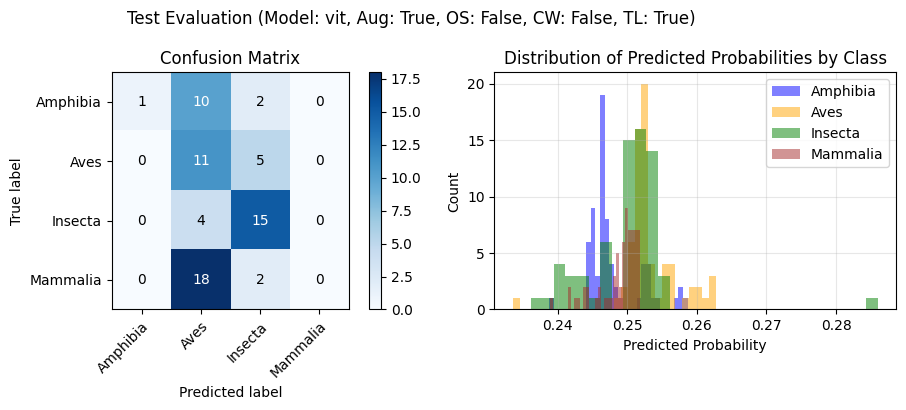

Classification report saved to: /share/crsp/lab/pkaiser/ddlin/mids/DATASCI207_Bird_Sounds/data/working/result_csvs/classification_report_256vit_model_256_aug_tl.csv

Classification Report:
              precision    recall  f1-score   support

    Amphibia       1.00      0.08      0.14        13
        Aves       0.26      0.69      0.37        16
     Insecta       0.62      0.79      0.70        19
    Mammalia       0.00      0.00      0.00        20

    accuracy                           0.40        68
   macro avg       0.47      0.39      0.30        68
weighted avg       0.43      0.40      0.31        68



array([1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 1, 1, 1, 2, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

In [ ]:
# 3. Use existing evaluation functions with ensemble predictions
plot_test_evaluation(y_true, ensemble_pred_prob, class_mapping=CLASS_MAPPING_DICT, cfg=cfg)

y_pred = np.argmax(ensemble_pred_prob, axis=1)
# print(classification_report(y_true, y_pred, target_names=CLASS_MAPPING_DICT.values()))
y_pred